In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')

# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

#### Dataset 불러오기

In [2]:
kospi_all = pd.read_csv('./dataset/data_kospi_all.csv')
kospi_bad = pd.read_csv('./dataset/data_kospi_bad.csv')
kospi_good = pd.read_csv('./dataset/data_kospi_good.csv')
kosdaq_all = pd.read_csv('./dataset/data_kosdaq_all.csv')
kosdaq_bad = pd.read_csv('./dataset/data_kosdaq_bad.csv')
kosdaq_good = pd.read_csv('./dataset/data_kosdaq_good.csv')

#### 함수

##### train, test 분리 + 데이터 불균형 처리 + 스케일링

In [3]:
def data(df):
    features = df.drop(['target'], axis=1)
    target = df[['target']]

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)
    X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [4]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [5]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### Logistic Regression

In [6]:
def LG(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

##### Decision Tree

In [7]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [8]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='bankruptcy.dot', class_names=["0", "1"], feature_names= df.drop(['target'], axis=1).columns, impurity=True, filled=True)

    with open('bankruptcy.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

##### SVM

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

##### XGBoost

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]}

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

____

#### 코스피

##### All

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.17591624801671601

예측 데이터 정확도
accuracy score : 0.612
precision score : 0.105
recall score : 0.582
f1 score : 0.178
roc score : 0.598
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.07208    0.07208 1.00000   0.13447    0.50000
0.30000   0.07602    0.07237 1.00000   0.13497    0.50212
0.40000   0.16907    0.07737 0.96364   0.14324    0.53549
0.50000   0.61206    0.10492 0.58182   0.17778    0.59811
0.60000   0.85321    0.08696 0.10909   0.09677    0.51005
0.70000   0.91874    0.23077 0.05455   0.08824    0.52021
0.80000   0.92792    0.00000 0.00000   0.00000    0.50000
0.90000   0.92792    0.00000 0.00000   0.00000    0.50000
None


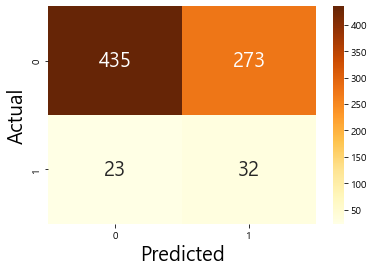

In [11]:
LG(kospi_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.14843078858021816

예측 데이터 정확도
accuracy score : 0.541
precision score : 0.082
recall score : 0.527
f1 score : 0.142
roc score : 0.535
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.19790    0.07481 0.89091   0.13803    0.51749
0.30000   0.37353    0.08119 0.74545   0.14643    0.54504
0.40000   0.37353    0.08119 0.74545   0.14643    0.54504
0.50000   0.54128    0.08215 0.52727   0.14216    0.53482
0.60000   0.80210    0.11290 0.25455   0.15642    0.54959
0.70000   0.89253    0.17073 0.12727   0.14583    0.53963
0.80000   0.91743    0.10000 0.01818   0.03077    0.50273
0.90000   0.91743    0.10000 0.01818   0.03077    0.50273
None


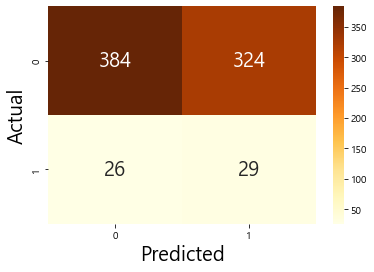

In [12]:
p_all = DT(kospi_all)

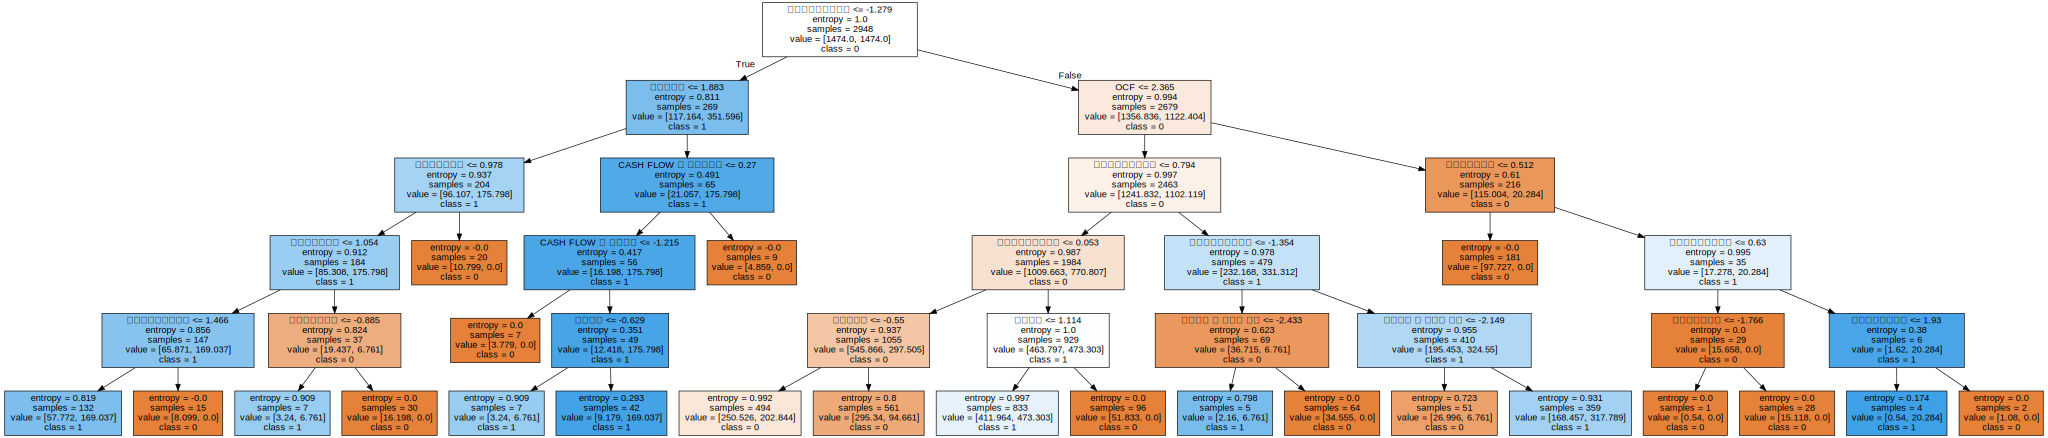

In [13]:
DT_vis(kospi_all, p_all)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.18016462455945068

예측 데이터 정확도
accuracy score : 0.679
precision score : 0.087
recall score : 0.364
f1 score : 0.140
roc score : 0.534


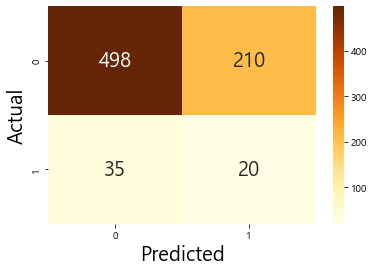

In [14]:
SVM(kospi_all, 'rbf')

In [15]:
# SVM(kospi_all, 'linear')

XGBoost

[23:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 12.967032967032967, 'silent': 1}
학습 데이터 정확도 :  0.18970454522115357

예측 데이터 정확도
accuracy score : 0.792
precision score : 0.100
recall score : 0.236
f1 score : 0.141
roc score : 0.536
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.26343    0.07820 0.85455   0.14329    0.53603
0.30000   0.43775    0.06912 0.5454

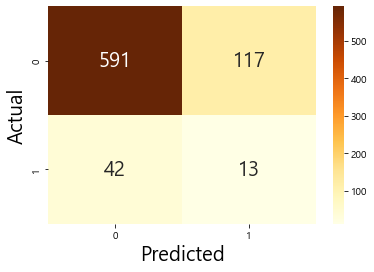

In [16]:
XGB(kospi_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.12348128292895735

예측 데이터 정확도
accuracy score : 0.579
precision score : 0.068
recall score : 0.556
f1 score : 0.122
roc score : 0.568
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.05240    0.05240 1.00000   0.09959    0.50000
0.30000   0.05240    0.05240 1.00000   0.09959    0.50000
0.40000   0.08151    0.04992 0.91667   0.09469    0.47600
0.50000   0.57933    0.06826 0.55556   0.12158    0.56810
0.60000   0.90102    0.05556 0.05556   0.05556    0.50166
0.70000   0.94905    1.00000 0.02778   0.05405    0.51389
0.80000   0.94760    0.00000 0.00000   0.00000    0.50000
0.90000   0.94760    0.00000 0.00000   0.00000    0.50000
None


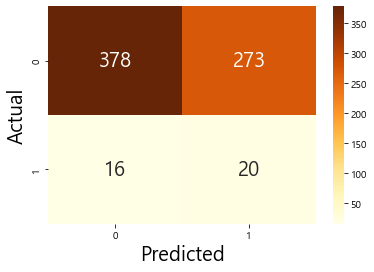

In [17]:
LG(kospi_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.12708068533488612

예측 데이터 정확도
accuracy score : 0.534
precision score : 0.053
recall score : 0.472
f1 score : 0.096
roc score : 0.505
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.28239    0.05108 0.72222   0.09541    0.49014
0.30000   0.28239    0.05108 0.72222   0.09541    0.49014
0.40000   0.28239    0.05108 0.72222   0.09541    0.49014
0.50000   0.53421    0.05346 0.47222   0.09605    0.50493
0.60000   0.87627    0.07018 0.11111   0.08602    0.51485
0.70000   0.87627    0.07018 0.11111   0.08602    0.51485
0.80000   0.93450    0.15385 0.05556   0.08163    0.51933
0.90000   0.94760    0.00000 0.00000   0.00000    0.50000
None


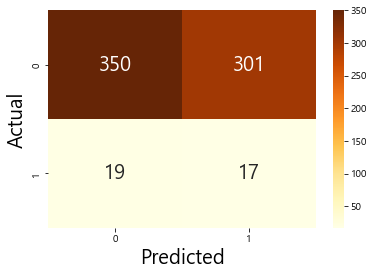

In [18]:
p_bad = DT(kospi_bad)

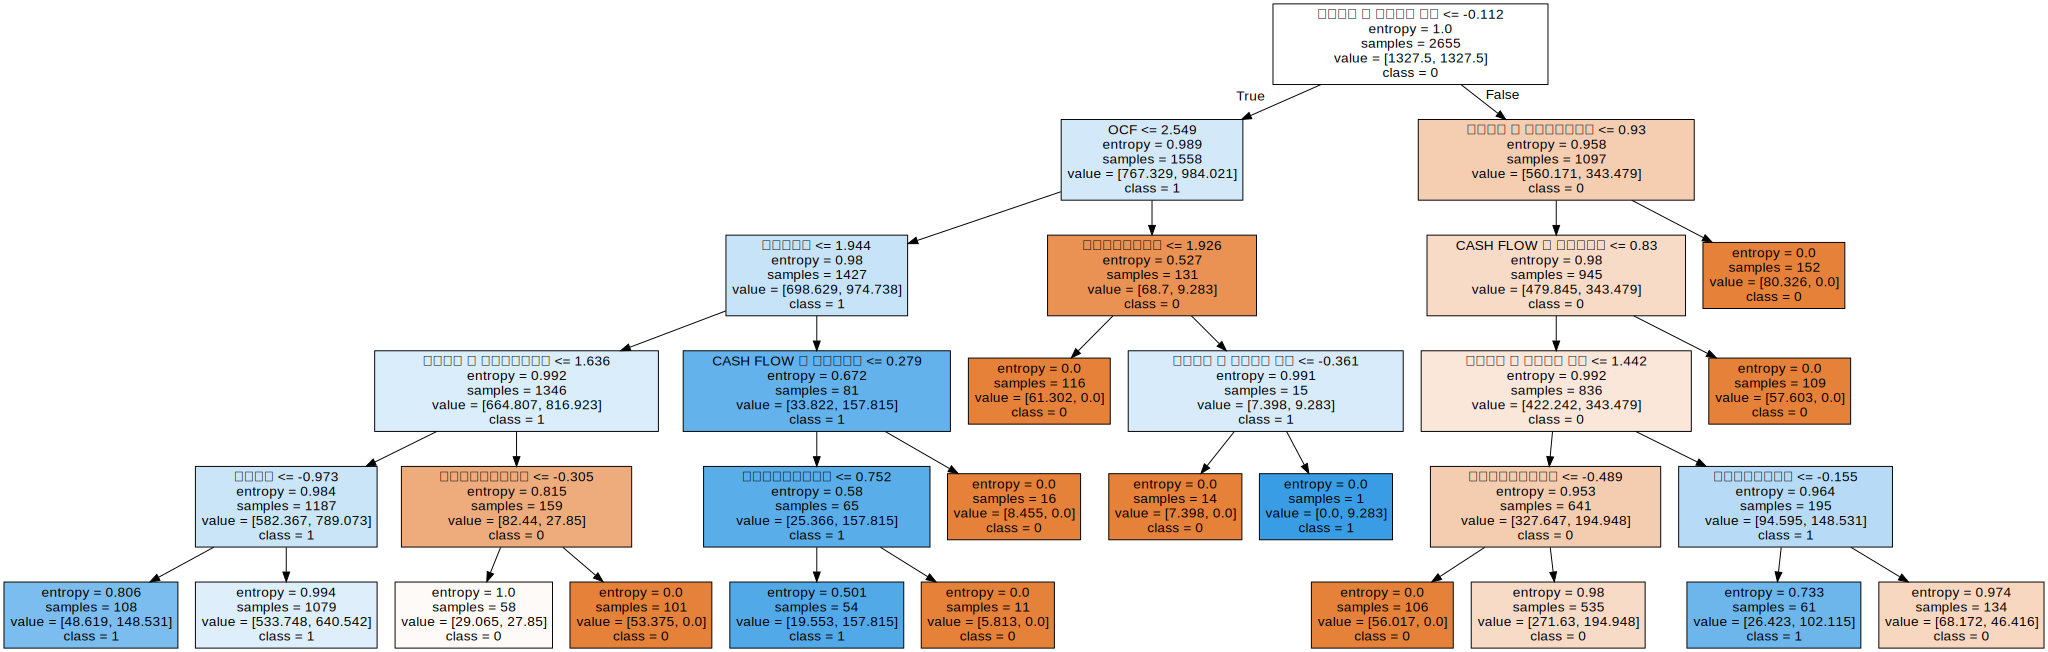

In [19]:
DT_vis(kospi_bad, p_bad)

SVM

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.13518145524613584

예측 데이터 정확도
accuracy score : 0.790
precision score : 0.065
recall score : 0.222
f1 score : 0.100
roc score : 0.522


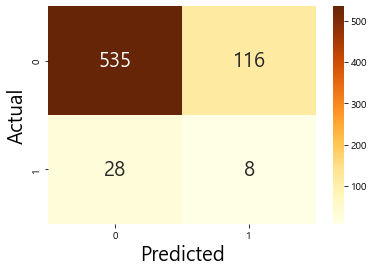

In [20]:
SVM(kospi_bad, 'rbf')

In [21]:
# SVM(kospi_bad, 'linear')

XGB

[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 10.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 18.189944134078214, 'silent': 1}
학습 데이터 정확도 :  0.15864014152688571

예측 데이터 정확도
accuracy score : 0.793
precision score : 0.058
recall score : 0.194
f1 score : 0.090
roc score : 0.510
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.27365    0.05736 0.83333   0.10733    0.53802
0.30000   0.46434    0.06316 0.666

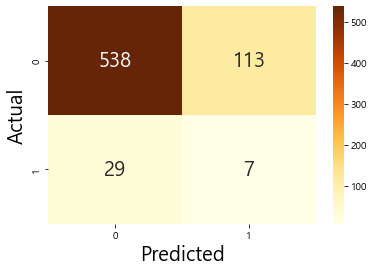

In [22]:
XGB(kospi_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.46317764392218824

예측 데이터 정확도
accuracy score : 0.658
precision score : 0.394
recall score : 0.684
f1 score : 0.500
roc score : 0.667
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.25000    0.25000 1.00000   0.40000    0.50000
0.30000   0.25000    0.25000 1.00000   0.40000    0.50000
0.40000   0.25000    0.25000 1.00000   0.40000    0.50000
0.50000   0.65789    0.39394 0.68421   0.50000    0.66667
0.60000   0.75000    0.00000 0.00000   0.00000    0.50000
0.70000   0.75000    0.00000 0.00000   0.00000    0.50000
0.80000   0.75000    0.00000 0.00000   0.00000    0.50000
0.90000   0.75000    0.00000 0.00000   0.00000    0.50000
None


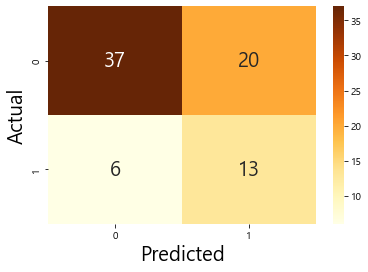

In [23]:
LG(kospi_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.4149497014613293

예측 데이터 정확도
accuracy score : 0.697
precision score : 0.375
recall score : 0.316
f1 score : 0.343
roc score : 0.570
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.42105    0.25490 0.68421   0.37143    0.50877
0.30000   0.42105    0.25490 0.68421   0.37143    0.50877
0.40000   0.42105    0.25490 0.68421   0.37143    0.50877
0.50000   0.69737    0.37500 0.31579   0.34286    0.57018
0.60000   0.69737    0.37500 0.31579   0.34286    0.57018
0.70000   0.69737    0.37500 0.31579   0.34286    0.57018
0.80000   0.67105    0.12500 0.05263   0.07407    0.46491
0.90000   0.67105    0.12500 0.05263   0.07407    0.46491
None


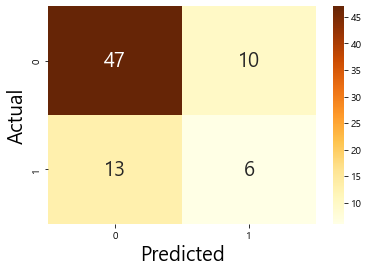

In [24]:
p_good = DT(kospi_good)

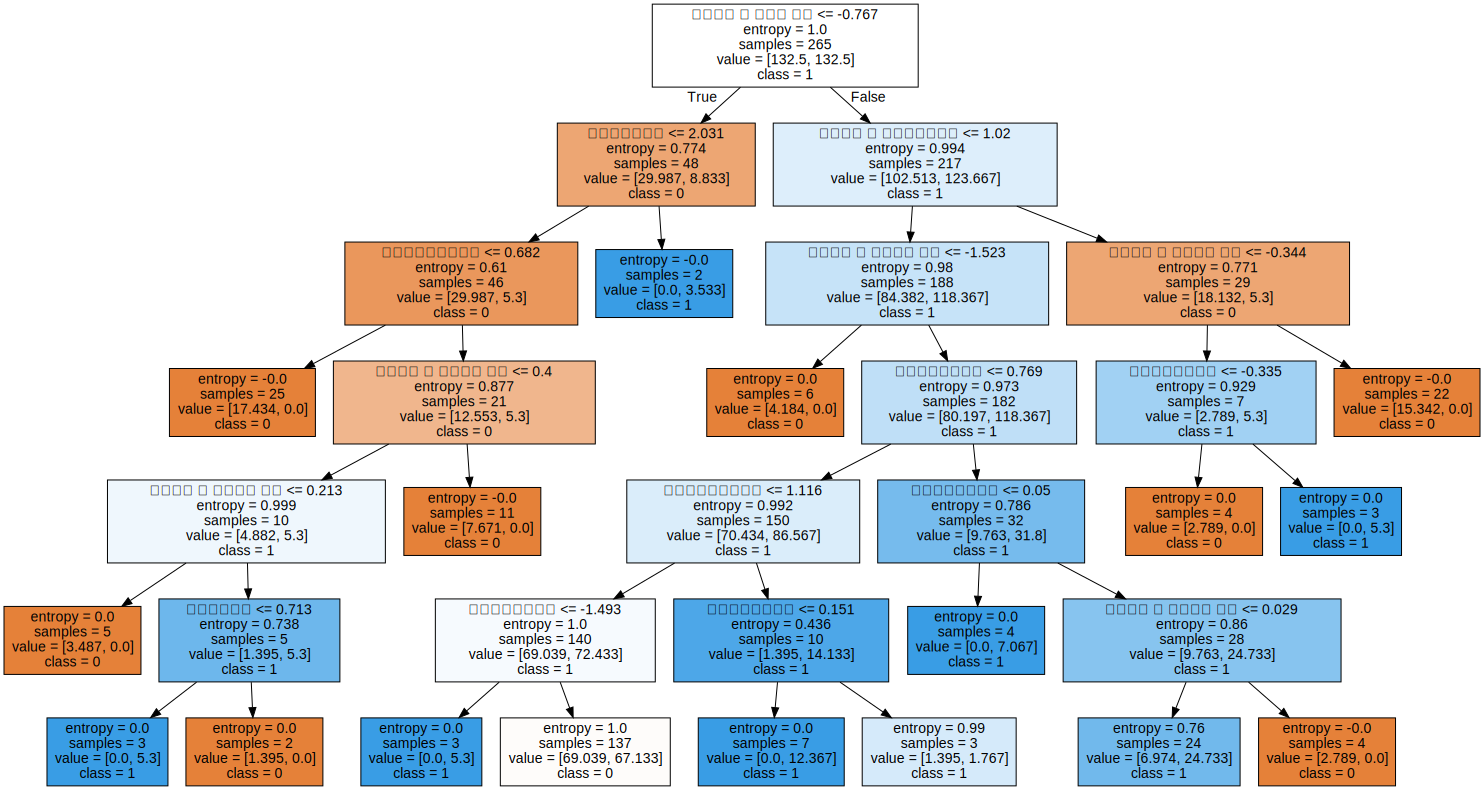

In [25]:
DT_vis(kospi_good, p_good)

SVM

최적 파라미터
 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.4678807509254363

예측 데이터 정확도
accuracy score : 0.303
precision score : 0.257
recall score : 0.947
f1 score : 0.404
roc score : 0.518


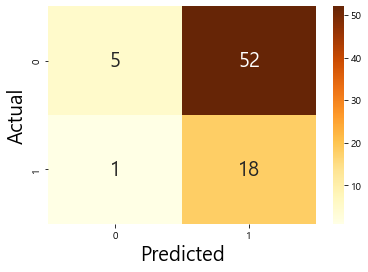

In [26]:
SVM(kospi_good, 'rbf')

In [27]:
# SVM(kospi_good, 'linear')

XGB

[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 10.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 3.021276595744681, 'silent': 1}
학습 데이터 정확도 :  0.48524729197663385

예측 데이터 정확도
accuracy score : 0.566
precision score : 0.325
recall score : 0.684
f1 score : 0.441
roc score : 0.605
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.30263    0.26389 1.00000   0.41758    0.53509
0.30000   0.39474    0.27119 0.84211

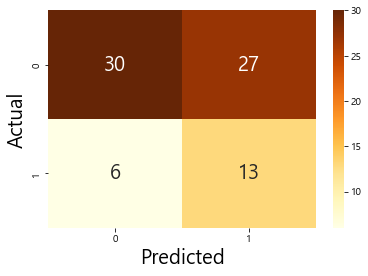

In [28]:
XGB(kospi_good)

#### 코스닥

##### ALL

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.21310403452117782

예측 데이터 정확도
accuracy score : 0.559
precision score : 0.122
recall score : 0.488
f1 score : 0.196
roc score : 0.528
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11002    0.11002 1.00000   0.19823    0.50000
0.30000   0.11002    0.11002 1.00000   0.19823    0.50000
0.40000   0.11002    0.11002 1.00000   0.19823    0.50000
0.50000   0.55903    0.12245 0.48780   0.19576    0.52782
0.60000   0.88998    0.00000 0.00000   0.00000    0.50000
0.70000   0.88998    0.00000 0.00000   0.00000    0.50000
0.80000   0.88998    0.00000 0.00000   0.00000    0.50000
0.90000   0.88998    0.00000 0.00000   0.00000    0.50000
None


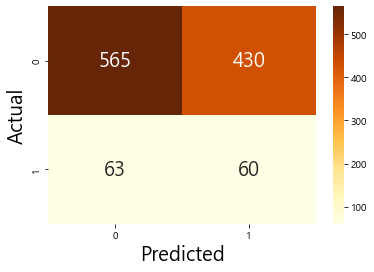

In [29]:
LG(kosdaq_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.19983685649920702

예측 데이터 정확도
accuracy score : 0.617
precision score : 0.112
recall score : 0.358
f1 score : 0.171
roc score : 0.503
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.17084    0.11420 0.96748   0.20429    0.51992
0.30000   0.17084    0.11420 0.96748   0.20429    0.51992
0.40000   0.17084    0.11420 0.96748   0.20429    0.51992
0.50000   0.61717    0.11196 0.35772   0.17054    0.50348
0.60000   0.77549    0.14045 0.20325   0.16611    0.52474
0.70000   0.82916    0.12222 0.08943   0.10329    0.50502
0.80000   0.88193    0.09091 0.00813   0.01493    0.49904
0.90000   0.88193    0.09091 0.00813   0.01493    0.49904
None


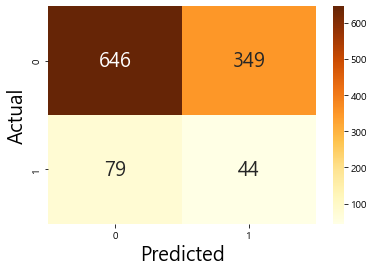

In [30]:
d_all = DT(kosdaq_all)

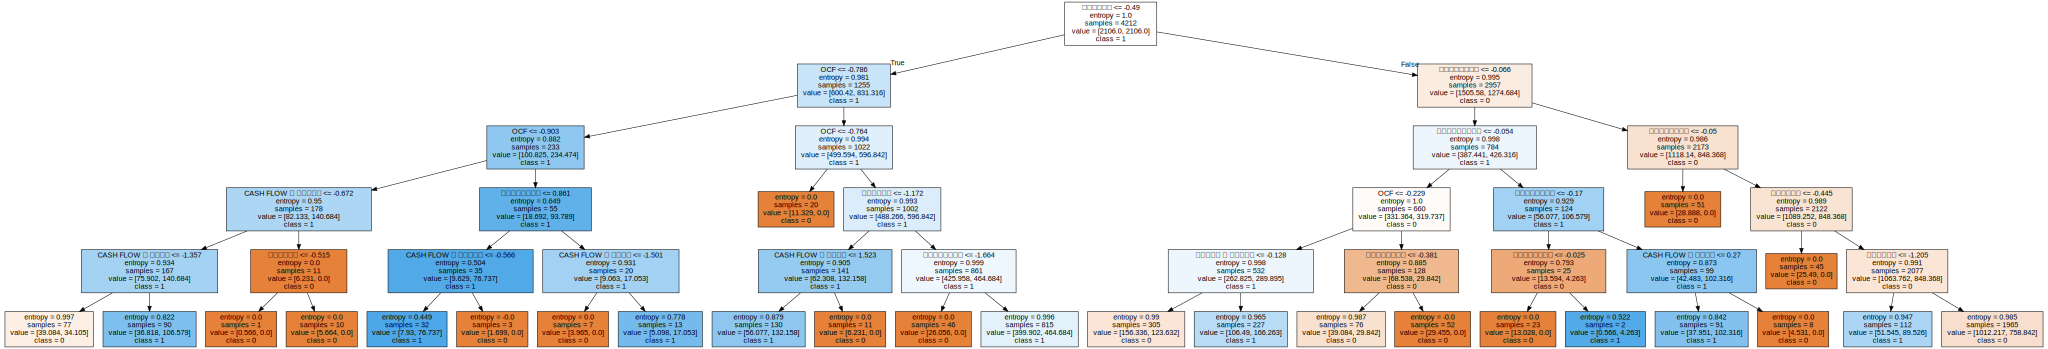

In [31]:
DT_vis(kosdaq_all, d_all)

SVM

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.22102249986219955

예측 데이터 정확도
accuracy score : 0.681
precision score : 0.156
recall score : 0.431
f1 score : 0.229
roc score : 0.571


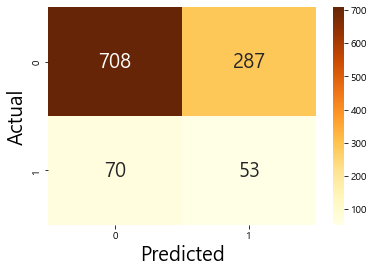

In [32]:
SVM(kosdaq_all, 'rbf')

In [33]:
# SVM(kosdaq_all, 'linear')

XGB

[00:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.056726094003242, 'silent': 1}
학습 데이터 정확도 :  0.20609655463713256

예측 데이터 정확도
accuracy score : 0.691
precision score : 0.137
recall score : 0.341
f1 score : 0.195
roc score : 0.538
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11270    0.11031 1.00000   0.19871    0.50151
0.30000   0.15921    0.11353 0.97561

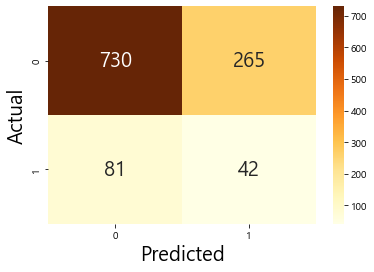

In [34]:
XGB(kosdaq_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.2115041064263404

예측 데이터 정확도
accuracy score : 0.594
precision score : 0.111
recall score : 0.465
f1 score : 0.179
roc score : 0.536
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.09492    0.09492 1.00000   0.17338    0.50000
0.30000   0.09588    0.09501 1.00000   0.17353    0.50053
0.40000   0.16874    0.09494 0.90909   0.17192    0.50010
0.50000   0.59444    0.11058 0.46465   0.17864    0.53635
0.60000   0.83126    0.11111 0.11111   0.11111    0.50895
0.70000   0.89262    0.00000 0.00000   0.00000    0.49311
0.80000   0.90508    0.00000 0.00000   0.00000    0.50000
0.90000   0.90508    0.00000 0.00000   0.00000    0.50000
None


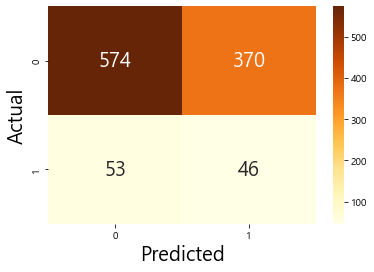

In [35]:
LG(kosdaq_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.19967278085185552

예측 데이터 정확도
accuracy score : 0.601
precision score : 0.093
recall score : 0.364
f1 score : 0.148
roc score : 0.495
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.24832    0.09658 0.82828   0.17300    0.50789
0.30000   0.24832    0.09658 0.82828   0.17300    0.50789
0.40000   0.38447    0.09897 0.67677   0.17268    0.51529
0.50000   0.60115    0.09254 0.36364   0.14754    0.49485
0.60000   0.67881    0.09028 0.26263   0.13437    0.49254
0.70000   0.85714    0.06897 0.04040   0.05096    0.49160
0.80000   0.89741    0.10000 0.01010   0.01835    0.50028
0.90000   0.89741    0.10000 0.01010   0.01835    0.50028
None


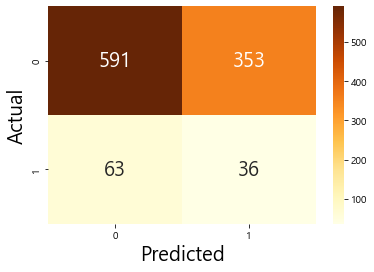

In [36]:
d_bad = DT(kosdaq_bad)

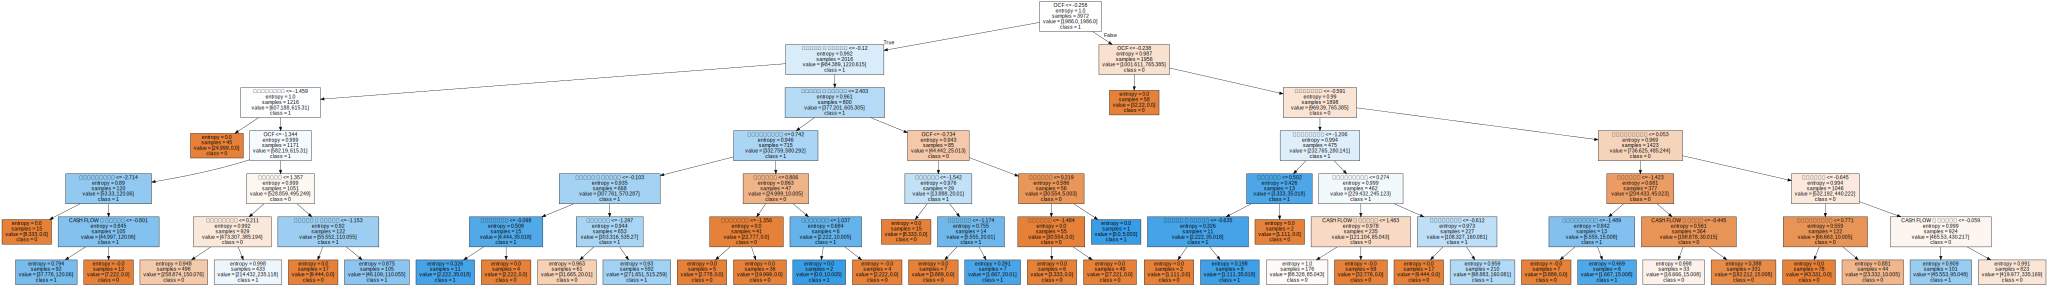

In [37]:
DT_vis(kosdaq_bad, d_bad)

SVM

최적 파라미터
 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.20706326956534477

예측 데이터 정확도
accuracy score : 0.570
precision score : 0.108
recall score : 0.485
f1 score : 0.176
roc score : 0.532


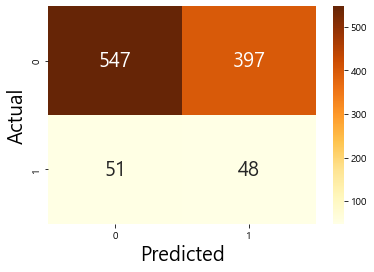

In [38]:
SVM(kosdaq_bad, 'rbf')

In [39]:
# SVM(kosdaq_bad, 'linear')

XGBoost

[00:13:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 10.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 9.51008064516129, 'silent': 1}
학습 데이터 정확도 :  0.1849966089083736

예측 데이터 정확도
accuracy score : 0.703
precision score : 0.119
recall score : 0.333
f1 score : 0.176
roc score : 0.537
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.10451    0.09584 1.00000   0.17491    0.50530
0.30000   0.22244    0.09453 0.83838 

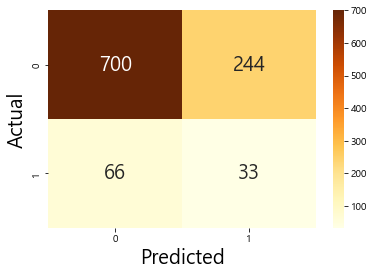

In [40]:
XGB(kosdaq_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5105025409373235

예측 데이터 정확도
accuracy score : 0.533
precision score : 0.366
recall score : 0.625
f1 score : 0.462
roc score : 0.558
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.33333    0.32432 1.00000   0.48980    0.50980
0.30000   0.37333    0.33333 0.95833   0.49462    0.52819
0.40000   0.45333    0.36066 0.91667   0.51765    0.57598
0.50000   0.53333    0.36585 0.62500   0.46154    0.55760
0.60000   0.62667    0.37500 0.25000   0.30000    0.52696
0.70000   0.66667    0.33333 0.04167   0.07407    0.50123
0.80000   0.68000    0.00000 0.00000   0.00000    0.50000
0.90000   0.68000    0.00000 0.00000   0.00000    0.50000
None


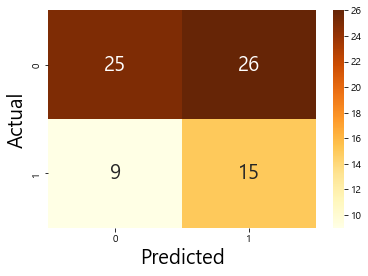

In [41]:
LG(kosdaq_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.41756024507889367

예측 데이터 정확도
accuracy score : 0.613
precision score : 0.424
recall score : 0.583
f1 score : 0.491
roc score : 0.605
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.41333    0.34848 0.95833   0.51111    0.55760
0.30000   0.41333    0.34848 0.95833   0.51111    0.55760
0.40000   0.56000    0.41509 0.91667   0.57143    0.65441
0.50000   0.61333    0.42424 0.58333   0.49123    0.60539
0.60000   0.60000    0.40000 0.50000   0.44444    0.57353
0.70000   0.58667    0.37931 0.45833   0.41509    0.55270
0.80000   0.65333    0.41667 0.20833   0.27778    0.53554
0.90000   0.65333    0.41667 0.20833   0.27778    0.53554
None


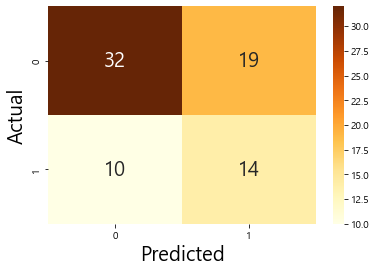

In [42]:
d_good = DT(kosdaq_good)

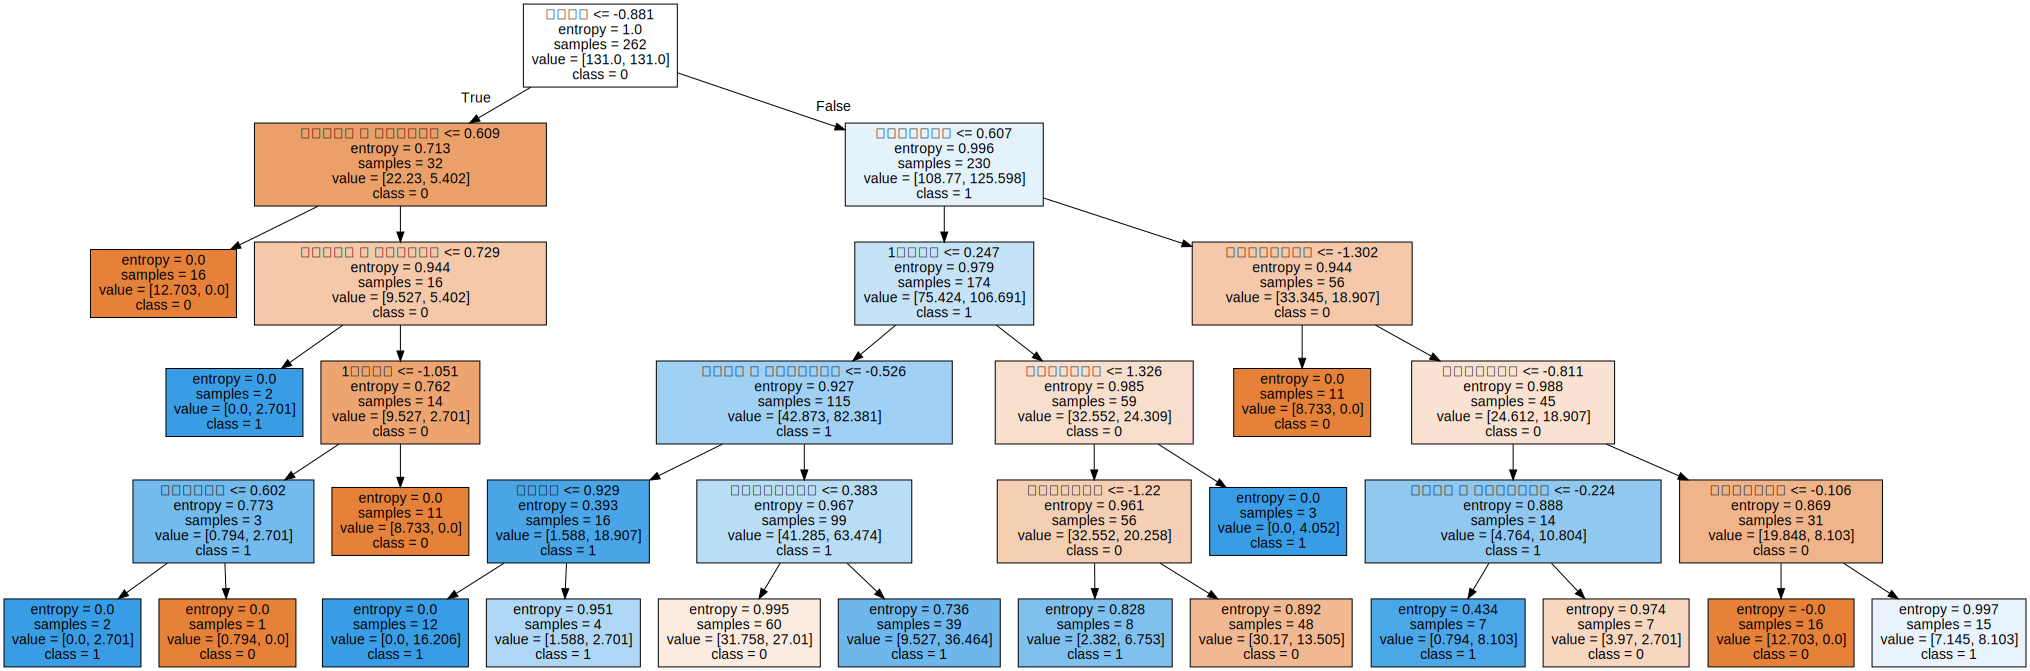

In [43]:
DT_vis(kosdaq_good, d_good)

SVM

최적 파라미터
 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.6242614615626605

예측 데이터 정확도
accuracy score : 0.453
precision score : 0.361
recall score : 0.917
f1 score : 0.518
roc score : 0.576


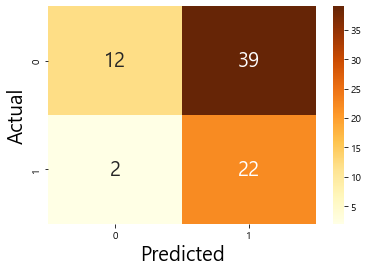

In [44]:
SVM(kosdaq_good, 'rbf')

In [45]:
# SVM(kosdaq_good, 'linear')

XGB

[00:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 10.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 2.0991735537190084, 'silent': 1}
학습 데이터 정확도 :  0.5287513144682432

예측 데이터 정확도
accuracy score : 0.587
precision score : 0.419
recall score : 0.750
f1 score : 0.537
roc score : 0.630
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.32000    0.32000 1.00000   0.48485    0.50000
0.30000   0.34667    0.32877 1.00000

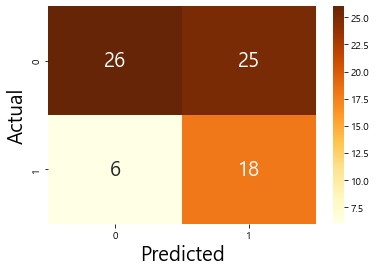

In [46]:
XGB(kosdaq_good)